In [5]:
fold_validation_patient = 'ACel'
fold_model_path = '../logs/cv-with-depth/2021-02-18-09:47:11_fold0/best_model_18_dsc=0.9763.pt'

In [6]:
import sys
sys.path.append('../models')
sys.path.append('../dataset_pericardium')
from unet_plain import UNet
from patients_dataset import PatientsDataset
import matplotlib.pyplot as plt
import numpy as np
import torch

In [7]:
dataset = PatientsDataset(
    patient_names=[fold_validation_patient],
    inputs_dir=os.path.join('../dataset_pericardium_manual_polar/', 'input'),
    labels_dir=os.path.join('../dataset_pericardium_manual_polar/', 'label'),
    image_size=128,
    random_sampling=False,
)

reading images...
preprocessing volumes...
resizing volumes...
normalizing volumes...
done creating dataset


In [8]:
def show_images_row(imgs, titles=None, rows=1, figsize=(6.4, 4.8), **kwargs):
    '''
       Display grid of cv2 images image
       :param img: list [cv::mat]
       :param title: titles
       :return: None
    '''
    assert ((titles is None) or (len(imgs) == len(titles)))
    num_images = len(imgs)

    if titles is None:
        titles = ['Image (%d)' % i for i in range(1, num_images + 1)]

    fig = plt.figure(figsize=figsize)
    for n, (image, title) in enumerate(zip(imgs, titles)):
        ax = fig.add_subplot(rows, np.ceil(num_images / float(rows)), n + 1)
        plt.imshow(image, **kwargs)
        ax.set_title(title)
        plt.axis('off')
    plt.show()

In [9]:
all_xs = []
all_ys = []
for (x, y) in dataset:
    all_xs.append(x.squeeze(0))
    all_ys.append(y.squeeze(0))

In [10]:
show_images_row(all_xs[20:24] + all_ys[20:24], rows=2)

TypeError: Invalid shape (2, 128, 128) for image data

In [11]:
model = UNet(in_channels=2, out_channels=1, device='cuda')
model.to('cuda')
model.load_state_dict(torch.load(fold_model_path))
model.eval()

UNet(
  (encoder1): Sequential(
    (enc1conv1): Conv2d(2, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc1norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc1relu1): ReLU(inplace=True)
    (enc1conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc1norm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc1relu2): ReLU(inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder2): Sequential(
    (enc2conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc2norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc2relu1): ReLU(inplace=True)
    (enc2conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc2norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

In [12]:
all_predicted_ys = []
for (x, y) in dataset:
    x = x.to('cuda')
    predicted_y = model(x.unsqueeze(0))
    all_predicted_ys.append(predicted_y.squeeze(0).squeeze(0).detach().cpu())

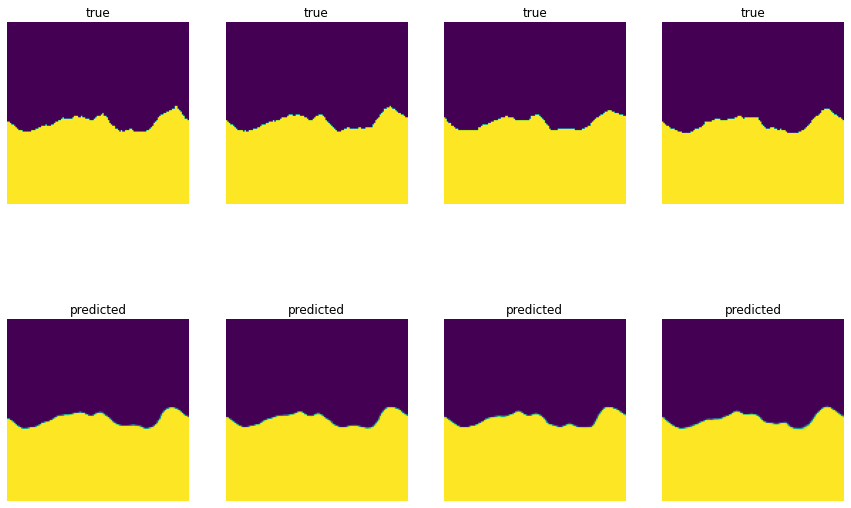

In [13]:
all_xs = [x[0] for x in all_xs]
show_images_row(
    all_ys[20:24] + all_predicted_ys[20:24], 
    titles=['true' for i in range(4)] + ['predicted' for i in range(4)], 
    rows=2,
    figsize=(15, 10))

In [10]:
print(all_predicted_ys[20])

tensor([[8.7405e-04, 6.7836e-04, 5.5802e-04,  ..., 6.0179e-04, 6.5048e-04,
         8.8018e-04],
        [7.7869e-04, 6.5458e-04, 5.1410e-04,  ..., 5.3923e-04, 6.2626e-04,
         5.1278e-04],
        [4.3523e-04, 5.4090e-04, 4.9541e-04,  ..., 4.4703e-04, 4.6841e-04,
         4.1714e-04],
        ...,
        [9.9949e-01, 9.9971e-01, 9.9975e-01,  ..., 9.9992e-01, 9.9989e-01,
         9.9964e-01],
        [9.9967e-01, 9.9969e-01, 9.9970e-01,  ..., 9.9991e-01, 9.9985e-01,
         9.9941e-01],
        [9.9913e-01, 9.9971e-01, 9.9972e-01,  ..., 9.9975e-01, 9.9977e-01,
         9.9871e-01]])


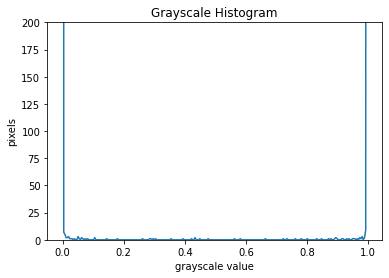

In [19]:
plt.figure()
plt.title("Grayscale Histogram")
plt.xlabel("grayscale value")
plt.ylabel("pixels")
histogram, bin_edges = np.histogram(all_predicted_ys[20], bins=256)
plt.plot(bin_edges[0:-1], histogram)  # <- or here
plt.ylim((0, 200))
plt.show()

In [14]:
volume = dataset.volumes[0][0].copy()
p = np.percentile(volume, 87)
plt.imshow(volume[20], vmin=-0.5, vmax=0.5)
print(volume.min())

TypeError: Invalid shape (128, 128, 2, 1) for image data

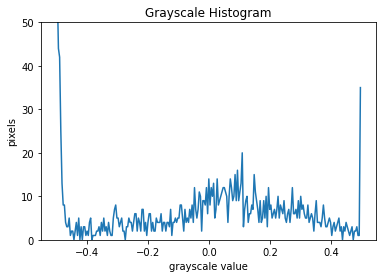

In [18]:
plt.figure()
plt.title("Grayscale Histogram")
plt.xlabel("grayscale value")
plt.ylabel("pixels")
histogram, bin_edges = np.histogram(volume[20], bins=256)
plt.plot(bin_edges[0:-1], histogram)  # <- or here
plt.ylim((0, 50))
plt.show()

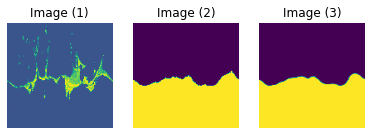

In [25]:
x = all_xs[20].detach().cpu().numpy().copy()
y_true = all_ys[20].detach().cpu().numpy().copy()
y_pred = all_predicted_ys[20].detach().cpu().numpy().copy()

show_images_row([x, y_true, y_pred])

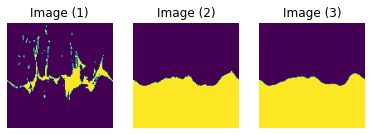

In [32]:
x[x > 0] = 1
x[x <= 0] = 0
y_pred[y_pred > 0.5] = 1
y_pred[y_pred <= 0] = 0
show_images_row([x, y_true, y_pred])

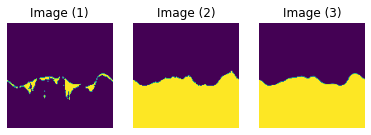

0.0


In [57]:
x *= y_pred
show_images_row([x, y_true, y_pred])
print(x.min())

['001.png', '002.png', '003.png', '004.png', '005.png', '006.png', '007.png', '008.png', '009.png', '010.png', '011.png', '012.png', '013.png', '014.png', '015.png', '016.png', '017.png', '018.png', '019.png', '020.png', '021.png', '022.png', '023.png', '024.png', '025.png', '026.png', '027.png', '028.png', '029.png', '030.png', '031.png', '032.png', '033.png', '034.png', '035.png', '036.png', '037.png', '038.png', '039.png']
255


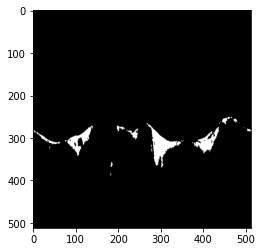

In [55]:
import cv2 as cv
import helpers as h
POLAR_EAT = '../gt_eat_polar/' + 'ACel/'
eat_labels = h.listdir(POLAR_EAT)
eat_labels.sort()
print(eat_labels)

eat_label = cv.imread(POLAR_EAT + eat_labels[20])
plt.imshow(eat_label)
print(eat_label.max())

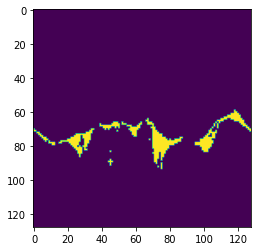

In [49]:
eat_true = all_xs[20].detach().cpu().numpy().copy()
eat_true[eat_true > 0] = 1
eat_true[eat_true <= 0] = 0
eat_true *= y_true
plt.imshow(eat_true)

-0.5


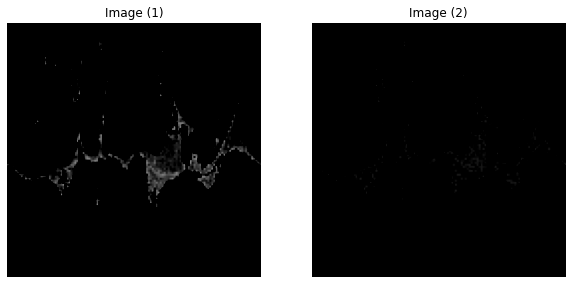

In [16]:
from skimage.exposure import rescale_intensity

def normalize_volume(volume):
    v = volume.copy()
    unnormalized = v.copy()
    v[v > 0.1] = 0
    #fat = rescale_intensity(fat, out_range=(0.1, 1))
    return v

normalized = normalize_volume(volume.copy())
print(np.median(normalized))

show_images_row([volume[20], normalized[20]], figsize=(10, 5), vmin=0, vmax=1, cmap="gray")

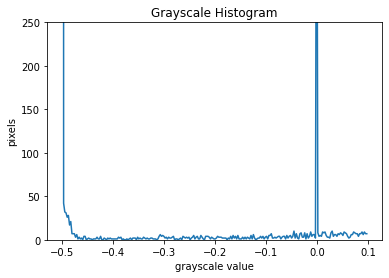

In [14]:
plt.figure()
plt.title("Grayscale Histogram")
plt.xlabel("grayscale value")
plt.ylabel("pixels")
histogram, bin_edges = np.histogram(normalized[20], bins=256)
plt.plot(bin_edges[0:-1], histogram)  # <- or here
plt.ylim((0, 250))
plt.show()

In [ ]:
volume = dataset.volumes[0][0].copy()
p = np.percentile(volume, 87)
plt.imshow(volume[20], vmin=-0.5, vmax=0.5)

In [13]:
def show_images_row(imgs, titles=None, rows=1, figsize=(6.4, 4.8), **kwargs):
    '''
       Display grid of cv2 images image
       :param img: list [cv::mat]
       :param title: titles
       :return: None
    '''
    assert ((titles is None) or (len(imgs) == len(titles)))
    num_images = len(imgs)

    if titles is None:
        titles = ['Image (%d)' % i for i in range(1, num_images + 1)]

    fig = plt.figure(figsize=figsize)
    for n, (image, title) in enumerate(zip(imgs, titles)):
        ax = fig.add_subplot(rows, np.ceil(num_images / float(rows)), n + 1)
        plt.imshow(image, **kwargs)
        ax.set_title(title)
        plt.axis('off')
    plt.show()

In [5]:
import sys
import os
sys.path.append('../models')
sys.path.append('../dataset_pericardium')
from unet_plain import UNet
from patients_dataset import PatientsDataset
import matplotlib.pyplot as plt
import numpy as np
import torch
sys.path.append('..')
import helpers as h
import cv2 as cv
from skimage.transform import resize

dataset_folder = '../dataset_pericardium_manual_polar/'
eats_folder = '../gt_eat_polar/'

folds = 20
run = '../logs/cv-with-depth/'
models = h.listdir(run)
models.sort()
patients = h.listdir(os.path.join('../dataset_pericardium_manual_polar/', 'input'))
patients.sort()

def dsc(y_pred, y_true):
    if not np.any(y_true):
        return 0.5
    else:
        return np.sum(y_pred[y_true == 1]) * 2.0 / (np.sum(y_pred) + np.sum(y_true))
    
all_dscs = []

for fold in range(folds):
    validation_patient = patients[fold]
    dataset = PatientsDataset(
        patient_names=[validation_patient],
        inputs_dir=os.path.join(dataset_folder, 'input'),
        labels_dir=os.path.join(dataset_folder, 'label'),
        image_size=128,
        random_sampling=False)

    fold_models_path = h.listdir(run + models[fold])
    fold_models_path.sort()
    fold_model_path = run + models[fold] + '/' + fold_models_path[-2]
    print(fold_model_path)

    model = UNet(in_channels=2, out_channels=1, device='cuda')
    model.to('cuda')
    model.load_state_dict(torch.load(fold_model_path))
    model.eval()

    all_xs = []
    all_ys = []
    all_predicted_ys = []

    for (x, y) in dataset:
        all_xs.append(x.squeeze(0).detach().cpu().numpy())
        all_ys.append(y.squeeze(0).detach().cpu().numpy())

        x = x.to('cuda')
        predicted_y = model(x.unsqueeze(0).detach())
        all_predicted_ys.append(predicted_y.squeeze(0).squeeze(0).detach().cpu().numpy())

    all_eats = []
    all_predicted_eats = []

    eat_label_files = h.listdir(eats_folder + validation_patient)
    eat_label_files.sort()
    for eat_file in eat_label_files:
        eat_file_path = eats_folder + validation_patient + "/" + eat_file
        eat_image = cv.imread(eat_file_path, cv.IMREAD_GRAYSCALE) / 255.0
        eat_image = resize(eat_image, output_shape=(128, 128), order=0, 
                           mode="constant", cval=0,anti_aliasing=False)
        all_eats.append(eat_image)
        
    for i in range(len(all_predicted_ys)):
        x = all_xs[i].copy()[0]
        y_true = all_ys[i].copy()
        y_pred = all_predicted_ys[i].copy()
        eat_true = all_eats[i]

        x[x > 0] = 1
        x[x <= 0] = 0
        y_pred[y_pred > 0.5] = 1
        y_pred[y_pred <= 0] = 0

        eat_pred = x * y_pred
        all_predicted_eats.append(eat_pred)
    
    dscs = []
    for i in range(len(all_predicted_eats)):
        if np.sum(all_ys[i]) < 0.1:
            dscs.append(0.5)
            continue
        dscs.append(dsc(all_predicted_eats[i], all_eats[i]))
    mean_dsc = np.mean(dscs)
    all_dscs.append(mean_dsc)

    dscs_sort = np.array(dscs).argsort()
    sorted_eats = np.array(all_eats)[dscs_sort]
    sorted_predicted_eats = np.array(all_predicted_eats)[dscs_sort]
    
    predicted_peri_folder = '../predicted_pericardium/'
    h.mkdir(predicted_peri_folder + validation_patient)
    for i, peri_image in enumerate(all_predicted_ys):
        file_name = f'{i + 1:03d}.png'
        peri_file_path = predicted_peri_folder + validation_patient + "/" + file_name
        
        peri_image = all_predicted_ys[i]
        peri_image[peri_image > 0.5] = 1
        peri_image[peri_image <=  0] = 0
        
        cv.imwrite(peri_file_path, peri_image * 255.0)
            
print(np.mean(all_dscs), np.std(all_dscs))

reading images...
preprocessing volumes...
resizing volumes...
normalizing volumes...
done creating dataset
../logs/cv-with-depth/2021-02-18-09:47:11_fold0/best_model_21_dsc=0.9678.pt
reading images...
preprocessing volumes...
resizing volumes...
normalizing volumes...
done creating dataset
../logs/cv-with-depth/2021-02-18-09:52:00_fold1/best_model_64_dsc=0.9863.pt
reading images...
preprocessing volumes...
resizing volumes...
normalizing volumes...
done creating dataset
../logs/cv-with-depth/2021-02-18-09:57:01_fold2/best_model_65_dsc=0.9689.pt
reading images...
preprocessing volumes...
resizing volumes...
normalizing volumes...
done creating dataset
../logs/cv-with-depth/2021-02-18-10:01:51_fold3/best_model_20_dsc=0.9796.pt
reading images...
preprocessing volumes...
resizing volumes...
normalizing volumes...
done creating dataset
../logs/cv-with-depth/2021-02-18-10:06:45_fold4/best_model_39_dsc=0.9670.pt
reading images...
preprocessing volumes...
resizing volumes...
normalizing volum